# Downloading, Filtering, Processing and Analysing Google Ngrams Fr-2012 for High Degree Prefixes Analaysis



# 1. Pre-processing of Google Ngrams (2012 version)

## A. Downloading / filtering google ngrams files

to download google ngrams data, we provide two shell scripts :
- `retrieve_googlengrams.fr.2012.sh` : this program download all necessary files with curl; files are stored in the `../data_ngram/googlengrams.fr.2012` subdirectory and then generate for each file a csv file (`<name_of_gz_file>.gz.cleaned.csv`) containing just the lines beginning with one of the prefix, containing concerned year and no POS tag (with _);
- `retrieve_googlengrams.fr.2020.sh`: the same with Google Ngrams version 2020 (stored in `../data_ngram/googlengrams.fr.2020`); as this version is not yet documented, we do not use it at the moment;

## B. Filter and generate merged 1-,2- and 3-grams files : 

- normalize strings : lowercase(), and convert `\s+--?\s+` to ' -'; 
- Check form of string (see regexp for query1gram, query2ram and query3gram) and drop string with integers;
- merge rows with same string values (after lowercase and normalization of `-`) : figures are the sum of respective values for given year;
- save skipped rows for each file for checking errors of parsing;
- merge all 1-grams, all 2-grams and all 3-grams data;
- save results in `../data/`: `fre.2012.prefixes.1.grams.1799-2009.csv`, `fre.2012.prefixes.2.grams.1799-2009.csv`,,`fre.2012.prefixes.3.grams.1799-2009.csv` 


In [9]:
import requests
import sys, csv,re, random, glob,os
import gzip
import pandas as pd

In [91]:
def read_google_ngram_to_df(filename, mindate=1799, daterange="1799-2009",query='.+'):
    ''' get google ngrams retrieved cleaned files and store into df
    format : ngram TAB year TAB match_count TAB volume_count NEWLINE
    '''
    data_columns = ['string', 'year', 'total_count','total_doc']   
    df1= pd.read_csv(filename, names = data_columns, usecols=['string', 'year', 'total_count'], sep='\t', error_bad_lines=True)
    # convert string to lower
    df1['string'] = df1.string.str.lower()  
    # convert '\s+--?\s+' to ' - '
    df1['string'] = df1.string.str.replace('\s+--?\s+', ' - ', regex=True)
    print("Initial df : ",df1.shape)
    # keep track of skipped lines to check
    dfbk = df1[(~df1['string'].str.contains(query, case=False)) | (df1.string.str.contains('\d'))]
    dfbk.to_csv(filename + '.skippedLines.csv',index=False)
    # just keep lines with string corresponding to query and without digit and with year > 1799
    df2 = df1[(df1['string'].str.contains(query, case=False)) & (~df1.string.str.contains('\d')) & (df1.year > 1799)]
    print("After string regex check : ", df2.shape)
    
    # merge identical string-year rows
    df3 = df2.groupby(['string','year'])['total_count'].sum().reset_index()
    print("After merging strings : ", df3.shape)

    # pivot the data so as to have years as columns and string (ngram) as row index
    df4 = df3.pivot_table(values='total_count', index='string', columns='year', fill_value=0) # index='string', aggfunc='mean'
    return df4


# main 

# synt : processing synthesis
synth={}

prefixes = ('archi','extra','hyper','hypra','maxi','méga','super','ultra')
mindate = 1799
maxdate = 2009
query1gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\w{2,}$'
query2gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s\w{2,}$'
query3gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+--?\s+\w{2,}$'
query_type='prefixes'
lang='fre'
str_range = str(mindate) + "-" + str(maxdate)
input_path = '../data_ngrams/googlengrams.fr.2012/'
output_path = '../data/'

# read google ngrams files downloaded beforehand and merge them
# 1-grams
files1 = glob.glob(input_path + 'googlebooks-fre-all-1gram*.cleaned.csv')
res = []
for f in files1:
    print("parsing " +  f )
    df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query1gram)
    res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
synth['1grams']= df1.shape[0]
df1.to_csv( output_path + 'fre.2012.prefixes.1.grams.' + str_range + ".csv")
print("***"*20)

# 2-grams
files2 = glob.glob(input_path + 'googlebooks-fre-all-2gram*.cleaned.csv')
res = []
for f in files2:
    print("parsing " +f )
    df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query2gram)
    res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
synth['2grams']= df1.shape[0]
df1.to_csv( output_path + 'fre.2012.prefixes.2.grams.' + str_range + ".csv")
print("***"*20)

# 3-grams
files3 = glob.glob(input_path + 'googlebooks-fre-all-3gram*.cleaned.csv')
res = []
for f in files3:
    print("parsing " + f )
    df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query3gram)
    res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
synth['3grams']= df1.shape[0]

df1.to_csv( output_path + 'fre.2012.prefixes.3.grams.' + str_range + ".csv")
print(synth)

## C. Filter with stoplists

In [12]:
stoplist1gram={}
stoplist2gram={}
stoplist3gram={}
# load 1-, 2- and 3-grams separately

with open('../data/stoplists/stopwords_1grams.txt', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            stoplist1gram[line.strip()]=1
with open('../data/stoplists/stopwords_2grams.txt', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            stoplist2gram[line.strip()]=1
with open('../data/stoplists/stopwords_3grams.txt', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            stoplist3gram[line.strip()]=1


print("Stoplist 1gram chargée : " + str(len(stoplist1gram.keys())) + " mots.")
print("Stoplist 2gram chargée : " + str(len(stoplist2gram.keys())) + " mots.")
print("Stoplist 3gram chargée : " + str(len(stoplist3gram.keys())) + " mots.")
total = len(stoplist1gram.keys()) + len(stoplist2gram.keys()) + len(stoplist3gram.keys())
print("Total Stoplists : " + str(total) + " mots.")



Stoplist 1gram chargée : 3923 mots.
Stoplist 2gram chargée : 1950 mots.
Stoplist 3gram chargée : 99 mots.
Total Stoplists : 5972 mots.


### Traitement des 1-grams

In [13]:

if os.path.isfile('../data/fre.2012.prefixes.1.grams.1799-2009.csv'):
    print("Loading the 1 gram big file (no pos)...")
    df= pd.read_csv('../data/fre.2012.prefixes.1.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=True)#, index_col=0 
else:
    print("Please generate fre.2012.prefixes.1.grams.1799-2009.csv with previous cells")
    exit()
print(df.info())



# difference stoplist / 1grams 
df2 = df[df.string.isin(stoplist1gram)] 
print(len(df['string'].unique()))
listdf = df2['string'].unique()
res = set(stoplist1gram.keys()) - set(listdf)
print(len(res),res)



#
# élimination stoplist
df = df[~df.string.isin(stoplist1gram)] # elimination mots dans les stoplists

print(df.info())
# generate prefix, word and sep columns 
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)(?:.*)$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)(.*)$'
df['prefix'] = df.string.str.extract(pref_re, expand=True)
df['word'] = df.string.str.extract(pref_re2, expand=True)
df['sep'] = 'FUSION'
print(df.info())
synth['1gram_after_stoplist']= df.shape[0]
#print(df.head())
print(df.info())
print(df.prefix.value_counts())

Loading the 1 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7356 entries, 0 to 7355
Columns: 211 entries, string to 2009
dtypes: int64(210), object(1)
memory usage: 11.8+ MB
None
7356
0 set()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 0 to 7355
Columns: 211 entries, string to 2009
dtypes: int64(210), object(1)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 0 to 7355
Columns: 214 entries, string to sep
dtypes: int64(210), object(4)
memory usage: 5.6+ MB
None


NameError: name 'synth' is not defined

In [95]:
columns = df.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df['full_count'] = df.apply(lambda x: x[periods].sum(), axis=1)
df.head()
df.to_csv("../data/df_prefixes_1grams.2012_after_stoplist.csv", index=False)

### 2-grams processing

In [96]:

if os.path.isfile('../data/fre.2012.prefixes.2.grams.1799-2009.csv'):
    print("Loading the 2 gram big file (no pos)...")
    df2= pd.read_csv('../data/fre.2012.prefixes.2.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=False)#, index_col=0 
else:
    print("Please first launch retrieve_google_2grams.py to generate fre.2012.prefixes.2.grams.1799-2009.csv")
    exit()

print(df2.info())

# difference stoplist / 2grams 
df3 = df2[df2.string.isin(stoplist2gram)] # stoplist
print(len(df3['string'].unique()))
listdf = df3['string'].unique()
res = set(stoplist2gram.keys()) - set(listdf)
print(len(res),res)




# élimination stoplist
df2 = df2[~df2.string.isin(stoplist2gram)]
df2.info()
df2.head()

# colonnes préfix et word
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:\w{2,})$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(\w{2,})$'
df2['prefix'] = df2.string.str.extract(pref_re, expand=True)
df2['word'] = df2.string.str.extract(pref_re2, expand=True)
df2['sep'] = 'ESPACE'
print(df2.info())
synth['2gram_after_stoplist']= df2.shape[0]

print(df2.prefix.value_counts())


Loading the 2 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 211 entries, string to 2009
dtypes: float64(124), int64(86), object(1)
memory usage: 4.2+ MB
None
1950
0 set()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 2574
Columns: 211 entries, string to 2009
dtypes: float64(124), int64(86), object(1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 2574
Columns: 214 entries, string to sep
dtypes: float64(124), int64(86), object(4)
memory usage: 1.0+ MB
None
extra    177
super    169
ultra    147
hyper     60
supra     59
archi     11
méga       4
maxi       2
Name: prefix, dtype: int64


In [97]:
columns = df2.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df2['full_count'] = df2.apply(lambda x: x[periods].sum(), axis=1)
df2.head()
df2.to_csv("../data/df_prefixes_2grams.2012_after_stoplist.csv", index=False)

### 3-grams processing

In [98]:

if os.path.isfile('../data/fre.2012.prefixes.3.grams.1799-2009.csv'):
    print("Loading the 3 gram big file (no pos)...")
    df3= pd.read_csv('../data/fre.2012.prefixes.3.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=False)#, index_col=0 
else:
    print("Please first launch retrieve_google_3grams.py to generate fre.2012.prefixes.3.grams.1799-2009.csv")
    exit()
print(df3.info())

# difference stoplist / 1grams 
df4 = df3[df3.string.isin(stoplist3gram)] 
print(len(df4['string'].unique()))
listdf = df4['string'].unique()
res = set(stoplist3gram) - set(listdf)
print(len(res),res)

# élimination stoplist
df3 = df3[~df3.string.isin(stoplist3gram)]
df3.info()

# colonnes préfix et word
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:--?)\s+(?:.*)$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:--?)\s+(.*)$'
df3['prefix'] = df3.string.str.extract(pref_re, expand=True)
df3['word'] = df3.string.str.extract(pref_re2, expand=True)
df3['sep'] = 'TIRET'
print(df3.info())
synth['3gram_after_stoplist']= df.shape[0]

print(df3.prefix.value_counts())
#print(df3.head())

Loading the 3 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Columns: 211 entries, string to 2009
dtypes: float64(97), int64(113), object(1)
memory usage: 4.0+ MB
None
98
1 {'supra - ouultracide'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365 entries, 0 to 2462
Columns: 211 entries, string to 2009
dtypes: float64(97), int64(113), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365 entries, 0 to 2462
Columns: 214 entries, string to sep
dtypes: float64(97), int64(113), object(4)
memory usage: 3.9+ MB
None
extra    817
ultra    552
super    381
supra    308
hyper    180
archi     94
méga      27
maxi       6
Name: prefix, dtype: int64


In [99]:
columns = df3.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df3['full_count'] = df3.apply(lambda x: x[periods].sum(), axis=1)
df3.head()
df3.to_csv("../data/df_prefixes_3grams.2012_after_stoplist.csv", index=False)

## D. Generate Merged Dataframe

Output : `../data/df_prefixes_allgrams.2012.after_stoplist.csv`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Columns: 215 entries, string to full_count
dtypes: float64(144), int64(67), object(4)
memory usage: 10.5+ MB
None
extra    1553
hyper    1541
super    1126
ultra     997
supra     708
archi     287
méga      203
maxi       12
Name: prefix, dtype: int64
{'1grams': 7356, '2grams': 2579, '3grams': 2463, '1gram_after_stoplist': 3433, '2gram_after_stoplist': 629, '3gram_after_stoplist': 3433, 'allgram_after_stoplist': 6427}


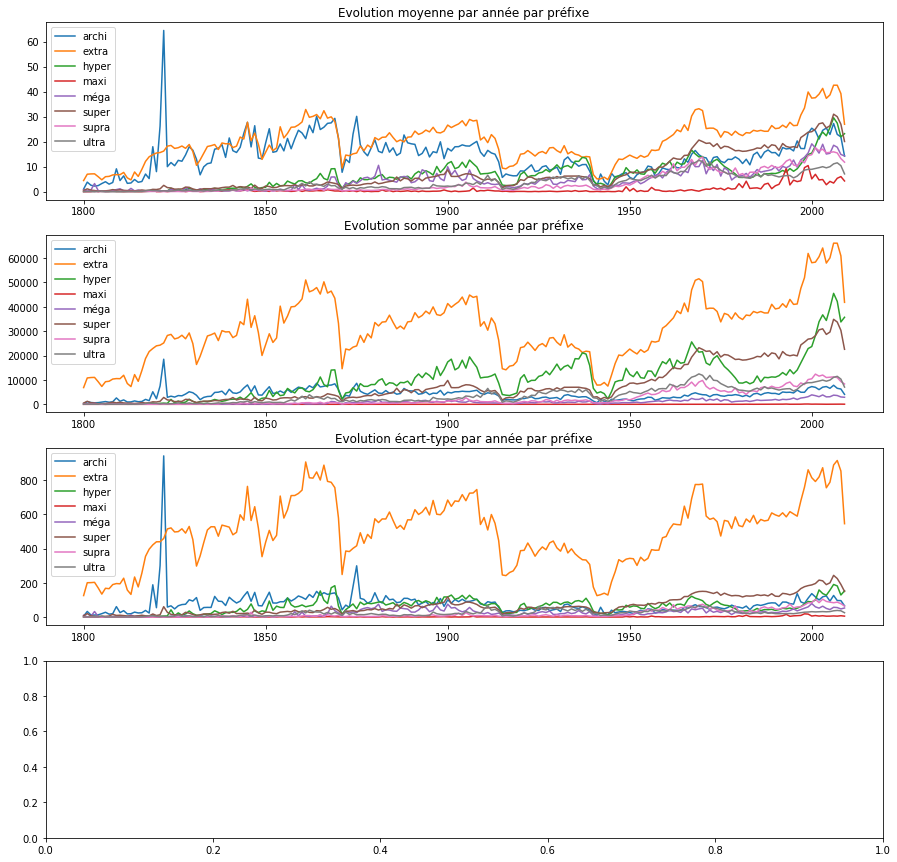

In [100]:


df4 = pd.concat([df,df2,df3],ignore_index=True)
print(df4.info())
print(df4.prefix.value_counts())
synth['allgram_after_stoplist']= df4.shape[0]

#print(df4.describe())
df4.to_csv("../data/df_prefixes_allgrams.2012.after_stoplist.csv", index=False)

print(synth)

In [187]:
# dataframe info
df = pd.read_csv("../data/df_prefixes_allgrams.2012.after_stoplist.csv")
print(df.info())
print(df.full_count.sum())
for k, grp in df.groupby('prefix'):
    print(k, grp['full_count'].count(),grp['full_count'].sum() )
print(df.prefix.value_counts())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Columns: 215 entries, string to full_count
dtypes: float64(144), int64(67), object(4)
memory usage: 10.5+ MB
None
12692395.0
archi 287 856837.0
extra 1553 6534840.0
hyper 1541 2132494.0
maxi 12 2122.0
méga 203 188887.0
super 1126 1716193.0
supra 708 516789.0
ultra 997 744233.0
extra    1553
hyper    1541
super    1126
ultra     997
supra     708
archi     287
méga      203
maxi       12
Name: prefix, dtype: int64


## E. Elimination des lexèmes n'exprimant pas le haut degré

fichiers source : 
- fichier des lexèmes à retenir :`../data/stoplists/phd.csv`
- fichier des données google Ngrams : `../data/df_prefixes_allgrams.2012.after_stoplist.csv`

sortie :
-  fichier des données : '../data/df_googlengrams_all_freq_abs.2012.csv'

In [15]:
#  just keep words which meaning is "high degree"
highdegree={}

with open('../data/stoplists/phd.csv', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            if len(line.strip())>0:
                highdegree[line.strip()]=1
            else:
                print("[" + line.strip() + "]")


print("Lexèmes exprimant le haut degré : " + str(len(highdegree.keys())))
#print(highdegree)

# lecture fichier initial
df = pd.read_csv("../data/df_prefixes_allgrams.2012.after_stoplist.csv")
print("Before phd filtering :")
print(df.info())
df2 = df[df.string.isin(highdegree)]

df2.to_csv('../data/df_prefixes_allgrams.2012.after_phd_filtering.csv', index=False)
#df2.to_csv('../data/df_googlengrams_all_freq_abs.2012.csv', index=False)
print("After phd filtering :")
print(df2.info())
#print(df2.head())
print(df2.full_count.sum())
print(df2.prefix.value_counts())

for k, grp in df2.groupby('prefix'):
    print(k, ", nbre formations distinctes : ", grp['full_count'].count(), "total occurrences : ", grp['full_count'].sum())
#df[['prefix','full_count']].pivot_table(index='prefix', aggfunc=['count', np.sum], margins=True)

Lexèmes exprimant le haut degré : 3460
Before phd filtering :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Columns: 215 entries, string to full_count
dtypes: float64(144), int64(67), object(4)
memory usage: 10.5+ MB
None
After phd filtering :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 8 to 6426
Columns: 215 entries, string to full_count
dtypes: float64(144), int64(67), object(4)
memory usage: 5.7+ MB
None
3141910.0
hyper    1421
ultra     839
super     754
extra     161
archi     127
méga      123
supra      22
maxi       12
Name: prefix, dtype: int64
archi , nbre formations distinctes :  127 total occurrences :  26314.0
extra , nbre formations distinctes :  161 total occurrences :  52675.0
hyper , nbre formations distinctes :  1421 total occurrences :  1995842.0
maxi , nbre formations distinctes :  12 total occurrences :  2122.0
méga , nbre formations distinctes :  123 total occurrences :  141203.0
super , nbre formations distinctes : 

## F. Ajout Parties du discours à partir données Morfetik

entrées:
- fichier morfetik: `../data/dico_morph/morfetik.xml`
- fichier de données :`../data/df_googlengrams_all_freq_abs.2012.csv`

fichier de sortie : `../data/df_googlengrams_all_freq_abs.pos.2012.csv`

In [5]:
# load morfetik data from xml and save it to pickle file (just launch once)
import re
import zipfile

word_pos={}
pos_val={}

with zipfile.ZipFile('../data/dico_morph/morfetik.xml.zip') as myzip:
    files = myzip.namelist()
    print(files)
    if 'morfetik.xml' in files:
        with myzip.open('morfetik.xml') as f:
            for line in f:
                #print(line)
                #print(line.strip().decode('utf-8'))
                # <morphlex forme="j" lemme="j" catgram="nm" cat="Nom" genre="M" num="P"/>
                res = re.search(r'^<morphlex\s+forme="([^"]+)".+?cat="([^"]+)"',line.strip().decode('utf-8'), re.I)
                if res:
                    word = res.group(1).strip()
                    pos = res.group(2).strip()
                    if pos == 'Inv':
                        pos='Adv'
                    if pos =='Dp':
                        pos='Det'
                    pos_val[pos]= pos_val.get(pos, 0)+1
                    #word_pos[word] = word_pos.get(word, []).append(pos)
                    if word in word_pos.keys():
                        pos_before = word_pos[word]
                        pos_before.append(pos)
                        word_pos[word] = pos_before
                    else:
                        word_pos[word] =  [pos]
                else:
                    print("No match for this line", line.strip().decode('utf-8'))
print(len(word_pos))
print(pos_val)
# convert set to string
for word in word_pos:
    word_pos[word] = "_".join(set(word_pos[word]))
# save to pickle for later use
import pickle
print(len(word_pos))
print(word_pos['le'])
filename = '../data/dico_morph/morfetik.pickle'
outfile = open(filename,'wb')
pickle.dump(word_pos,outfile)
outfile.close()

['morfetik.xml']
No match for this line b'<dico version="1.1" name="Morfetik" auteur="LDI-UMR7187" type="morpho"><morphlex forme="au" lemme="au" catgram="D:D\xc3\xa9f" cat="Dp" genre="M" num="S" notes="\xc3\xa0+le"/>\n'
No match for this line b'</dico>'
557399
{'Det': 266, 'Vrb': 519349, 'Adj': 97019, 'Nom': 138600, 'Adv': 2184}
557399
Det


In [19]:
# now assign pos to every word in df
import pickle
import pandas as pd
word_pos = pickle.load(open('../data/dico_morph/morfetik.pickle','rb'))

dftmp = pd.read_csv("../data/df_prefixes_allgrams.2012.after_phd_filtering.csv")
print(dftmp.info())

dftmp['pos'] = dftmp['word'].map(word_pos) 
#dftmp.to_csv('../data/df_googlengrams_all_freq_abs.pos.2012.csv', index=False)
dftmp.to_csv('../data/df_prefixes_allgrams.2012.after_pos_tagging.csv', index=False)
dftmp.to_csv('../data/reference/df_prefixes_allgrams.2012.freq_abs.csv', index=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Columns: 215 entries, string to full_count
dtypes: float64(144), int64(67), object(4)
memory usage: 5.7+ MB
None


## G. Generate final dataframe without outliers

outliers definition : all string whose full_count is outside the 0.975 quantile (from standard deviation)


sortie : `../data/reference/df_prefixes_allgrams.2012.freq_abs.no_outliers.csv`

In [20]:
# source file
df = pd.read_csv('../data/df_prefixes_allgrams.2012.after_pos_tagging.csv')
print("Before phd filtering :")
print(df.info())

df_rel2 = df[df.full_count < df.full_count.quantile(0.975)]
df_rel3 = df[df.full_count > df.full_count.quantile(0.975)]
# save outliers in stoplist dir
df_rel3.to_csv("../data/stoplists/df_prefixes_allgrams.2012.outliers.csv", index=False, columns=['string'])

print(df_rel2.info())
df_rel2.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_abs.no_outliers.csv", index=False)


Before phd filtering :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Columns: 216 entries, string to pos
dtypes: float64(144), int64(67), object(5)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3372 entries, 0 to 3458
Columns: 216 entries, string to pos
dtypes: float64(144), int64(67), object(5)
memory usage: 5.6+ MB
None


## H. Generate version for Néoveille visualization


sortie : `../data/reference/df_googlengrams_neoveille.freq_abs.2012.csv`

In [22]:
import re
df_rel2 = pd.read_csv("../data/reference/df_prefixes_allgrams.2012.freq_abs.no_outliers.csv")
# for visualization in néoveille (no outliers)
columns = df_rel2.columns
print(df_rel2.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel2.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep','pos']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep','pos'], value_name = "freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_abs.no_outliers.neoveille.csv", index=False)


Index(['string', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2005', '2006', '2007', '2008', '2009', 'prefix', 'word', 'sep',
       'full_count', 'pos'],
      dtype='object', length=216)
<class 'pandas.core.frame.DataFrame'>
Index: 143025 entries, 9 to 708112
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   string  143025 non-null  object 
 1   prefix  143025 non-null  object 
 2   word    143025 non-null  object 
 3   sep     143025 non-null  object 
 4   pos     143025 non-null  object 
 5   year    143025 non-null  object 
 6   freq    143025 non-null  float64
dtypes: float64(1), object(6)
memory usage: 8.7+ MB
None
              string prefix       word     sep          pos  year  freq
9        archicomble  archi     comble  FUSION  Vrb_Nom_Adj  1800   2.0
736   hyperorganique  hyper  organique  FUSION          Adj  1800   6.0
801    hyperphysique  hyper   physique

In [24]:
# the same with all data (begore phd filtering)
print(df_rel2.info())
df_rel2 = pd.read_csv('../data/reference/df_prefixes_allgrams.2012.freq_abs.csv')
#df_rel2 = pd.read_csv("../data/reference/df_googlengrams_all_freq_abs.pos.no_outliers.2012.csv")
# for visualization in néoveille (no outliers)
columns = df_rel2.columns
print(df_rel2.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel2.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep','pos']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep','pos'], value_name = "freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_abs.neoveille.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Columns: 216 entries, string to pos
dtypes: float64(144), int64(67), object(5)
memory usage: 5.7+ MB
None
Index(['string', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2005', '2006', '2007', '2008', '2009', 'prefix', 'word', 'sep',
       'full_count', 'pos'],
      dtype='object', length=216)
<class 'pandas.core.frame.DataFrame'>
Index: 151633 entries, 9 to 726382
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   string  151633 non-null  object 
 1   prefix  151633 non-null  object 
 2   word    151633 non-null  object 
 3   sep     151633 non-null  object 
 4   pos     151633 non-null  object 
 5   year    151633 non-null  object 
 6   freq    151633 non-null  float64
dtypes: float64(1), object(6)
memory usage: 9.3+ MB
None
              string prefix       word     sep          pos  year  freq
9 

## I. Generate Dataframe with Relative Frequency

In [8]:
import requests
def load_total_counts(corpus_id, start_year, end_year):
    '''
    This function loads the total counts for a given corpus from Google's source data.
    '''
    # map from id to url
    id_to_url= {
    15: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-all-totalcounts-20120701.txt',
    17: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-us-all-totalcounts-20120701.txt',
    18: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-gb-all-totalcounts-20120701.txt',
    16: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-fiction-all-totalcounts-20120701.txt',
    23: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-chi-sim-all-totalcounts-20120701.txt',
    19: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-fre-all-totalcounts-20120701.txt',
    20: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-ger-all-totalcounts-20120701.txt',
    24: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-heb-all-totalcounts-20120701.txt',
    22: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-ita-all-totalcounts-20120701.txt',
    25: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-rus-all-totalcounts-20120701.txt',
    21: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-spa-all-totalcounts-20120701.txt'
    }
    hdr='Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:10.0) Gecko/20100101 Firefox/10.0'
    headers={'User-Agent':hdr}
    resp = requests.get(id_to_url[corpus_id],headers=headers)
    resp.raise_for_status()
    response = resp.text
    #print(response)
    #response = urllib2.urlopen(urllib2.Request(id_to_url[corpus_id]))
    #total_counts = []
    total_counts2 = {}
    data = response.split("\t")
    for row in data:
        #print (row)
        #continue
        # first and last rows are empty, so a try...except is needed
        try:
            year, word_count, _, _ = row.split(',')
            #print(start_year)
            #print(end_year)
            #print(year)
            if int(year) >= start_year and int(year) <= end_year:
                #if int(year) in range(1935,1950):
                #    print(row)
                #print(year)
                #print(word_count)
                #total_counts.append(int(word_count))
                total_counts2[year]=int(word_count)
                #print(total_counts)
        except ValueError:
            pass
        
    return total_counts2

100248950864
True


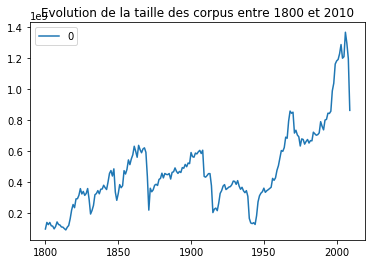

In [9]:


# load totals of tokens per corpus year
totals = load_total_counts(19,1800,2009)
print(sum(totals.values()))
pd.DataFrame.from_dict(totals, orient='index').plot(title="Evolution de la taille des corpus entre 1800 et 2010")

# save totals to csv as reference
with open('../data/reference/googlengrams.2012.corpus_info.csv', 'w') as f:
    for key in totals.keys():
        f.write("%s,%s\n"%(key,totals[key]))
# and to pickle file
import pickle
with open('../data/reference/googlengrams.2012.corpus_info.pickle', 'wb') as handle:
    pickle.dump(totals, handle) # , protocol=pickle.HIGHEST_PROTOCOL

with open('../data/reference/googlengrams.2012.corpus_info.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(totals == b)

- entrée : `../data/reference/df_googlengrams_all_freq_abs.pos.2012.csv`
- sortie : `../data/reference/df_googlengrams_all_freq_rel.2012.csv`

In [25]:
# generate df_rel dataframe (relative frequency = (absolute frequency / total frequency for year) * 100000)
df4 = pd.read_csv('../data/reference/df_prefixes_allgrams.2012.freq_abs.no_outliers.csv')
df_rel = df4.copy(deep=True)

# load totals of tokens per corpus year
try:
    totals
except:
    totals = load_total_counts(19,1800,2009)

# calculate relative frequency for each column

for i in range(1800,2010):
    df_rel[str(i) + '_freqrel'] = (df_rel[str(i)] / totals[str(i)]) * 1000000
    

# remove absolute frequency for df (relative frequency used for clustering and plotting)
df_rel = df_rel.drop([str(i) for i in range(1800,2010)], axis=1)
df_rel.columns = df_rel.columns.str.replace('_freqrel', '')

df_rel.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_rel.no_outliers.csv", index=False)
#print(df_rel.head())
print(df_rel.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Columns: 216 entries, string to 2009
dtypes: float64(211), object(5)
memory usage: 5.6+ MB
None


In [26]:
# the same with all data (before phd filtering)
# generate df_rel dataframe (relative frequency = (absolute frequency / total frequency for year) * 100000)
#df4 = pd.read_csv('../data/reference/df_googlengrams_all_freq_abs.pos.no_outliers.2012.csv')
#df7.to_csv("../data/reference/df_googlengrams_all_data_neoveille.freq_abs.2012.csv", index=False)
df4 = pd.read_csv('../data/reference/df_prefixes_allgrams.2012.freq_abs.csv')
df_rel = df4.copy(deep=True)

# load totals of tokens per corpus year
try:
    totals
except:
    totals = load_total_counts(19,1800,2009)

# calculate relative frequency for each column

for i in range(1800,2010):
    df_rel[str(i) + '_freqrel'] = (df_rel[str(i)] / totals[str(i)]) * 1000000
    

# remove absolute frequency for df (relative frequency used for clustering and plotting)
df_rel = df_rel.drop([str(i) for i in range(1800,2010)], axis=1)
df_rel.columns = df_rel.columns.str.replace('_freqrel', '')

df_rel.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_rel.csv", index=False)
#print(df_rel.head())
print(df_rel.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Columns: 216 entries, string to 2009
dtypes: float64(211), object(5)
memory usage: 5.7+ MB
None


# for visualization in néoveille

entrée : `../data/reference/df_googlengrams_all_freq_rel.no_outliers.2012.csv`

sortie : `../data/reference/df_googlengrams_neoveille.freqrel.2012.csv`

In [27]:

df_rel = pd.read_csv("../data/reference/df_prefixes_allgrams.2012.freq_rel.no_outliers.csv")

#print(df_rel.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep','pos']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep','pos'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_rel.no_outliers.neoveille.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 143025 entries, 9 to 708112
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   string    143025 non-null  object 
 1   prefix    143025 non-null  object 
 2   word      143025 non-null  object 
 3   sep       143025 non-null  object 
 4   pos       143025 non-null  object 
 5   year      143025 non-null  object 
 6   rel_freq  143025 non-null  float64
dtypes: float64(1), object(6)
memory usage: 8.7+ MB
None
              string prefix       word     sep          pos  year  rel_freq
9        archicomble  archi     comble  FUSION  Vrb_Nom_Adj  1800  0.020609
736   hyperorganique  hyper  organique  FUSION          Adj  1800  0.061828
801    hyperphysique  hyper   physique  FUSION      Nom_Adj  1800  0.030914
802   hyperphysiques  hyper  physiques  FUSION      Nom_Adj  1800  0.020609
1371      supercargo  super      cargo  FUSION      Nom_Adj  1800  0.020609


In [28]:
# the same for all data (before phd filtering)
df_rel = pd.read_csv("../data/reference/df_prefixes_allgrams.2012.freq_rel.csv")

#df_rel = pd.read_csv("../data/reference/df_googlengrams_all_freq_rel.2012.csv")

#print(df_rel.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep','pos']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep','pos'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/reference/df_prefixes_allgrams.2012.freq_rel.neoveille.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 151633 entries, 9 to 726382
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   string    151633 non-null  object 
 1   prefix    151633 non-null  object 
 2   word      151633 non-null  object 
 3   sep       151633 non-null  object 
 4   pos       151633 non-null  object 
 5   year      151633 non-null  object 
 6   rel_freq  151633 non-null  float64
dtypes: float64(1), object(6)
memory usage: 9.3+ MB
None
              string prefix       word     sep          pos  year  rel_freq
9        archicomble  archi     comble  FUSION  Vrb_Nom_Adj  1800  0.020609
759   hyperorganique  hyper  organique  FUSION          Adj  1800  0.061828
825    hyperphysique  hyper   physique  FUSION      Nom_Adj  1800  0.030914
826   hyperphysiques  hyper  physiques  FUSION      Nom_Adj  1800  0.020609
1190    hypertrophie  hyper    trophie  FUSION          Nom  1800  0.010305
